# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
import matplotlib

# User input

In [120]:
# defining the prediction type (angle based or distance based)
USE_DISTANCE_MODEL = True # set this to true to use distance for the model input or to false to use angles for the model input
#ANN_ANGLE_MODEL_FILE = 'Peak_Reflected_Pressure_ANN_2_nodrop_noscale.h5'
ANN_DISTANCE_MODEL_FILE = 'Arrival_ANN_1_nodrop_noscale.h5'
EXPORT_UNIQUE_ANGLES_OR_DISTANCES = True # set this to true to write the file with unique values of angles or distances

# defining parameters for neural network prediction
EXPLOSIVE_MASS = 15.2
DISTANCE_EXPLOSIVE_TO_SURFACE = 5.7
CORNER_COORDINATES_OF_SURFACE = ([0, 0], [7, 0], [7, 8.6], [0, 8.6])  # ll, lr, ul, ur
EXPLOSIVE_POSITION = [0, 0]
MESH_SIZE = 0.01
IS_TNT = True # set this to True if the input dataset is for TNT, and false for CompB

# defining parameters for numerical analysis results processing
#NUMERICAL_ANGLE_BASED_PREDICTION_FILE = 'angle_based_numerical_prediction.csv'
NUMERICAL_DISTANCE_BASED_PREDICTION_FILE = 'distance_based_numerical_prediction.csv'

# Defining functions

In [123]:
def generate_surface_coordinates(corner_coordinates, mesh_size):
    ll, lr, ul, ur = corner_coordinates

    # Generate grid of coordinates with mesh size
    x_range = np.arange(ll[0], lr[0] + mesh_size, mesh_size)
    y_range = np.arange(ll[1], ul[1] + mesh_size, mesh_size)[::-1]  # Reverse y_range to match the matrix orientation
    x_coords, y_coords = np.meshgrid(x_range, y_range)

    # Create a 2D matrix with coordinates in corresponding positions
    surface_matrix = np.empty_like(x_coords, dtype=object)
    for i in range(surface_matrix.shape[0]):
        for j in range(surface_matrix.shape[1]):
            surface_matrix[i, j] = (x_coords[i, j], y_coords[i, j])

    return surface_matrix

def calculate_angles(surface_matrix, distance_explosive_to_surface):
    origin_x, origin_y = 0, 0

    angle_surface_matrix = np.empty(surface_matrix.shape, dtype=object)
    for i in range(surface_matrix.shape[0]):
        for j in range(surface_matrix.shape[1]):
            distance_from_origin_to_point = np.sqrt((surface_matrix[i, j][0] - origin_x) ** 2 + (surface_matrix[i, j][1] - origin_y) ** 2)
            angle_radians = np.arctan(distance_from_origin_to_point/distance_explosive_to_surface)  # find the angle
            angle_degrees = np.round(np.degrees(angle_radians),0)  # Convert radians to degrees, define the required precision
            angle_surface_matrix[i, j] = angle_degrees  # Store angle in degrees
    return angle_surface_matrix

def calculate_distances(surface_matrix, distance_explosive_to_surface):
    origin_x, origin_y = 0, 0

    distance_surface_matrix = np.empty(surface_matrix.shape, dtype=object)
    for i in range(surface_matrix.shape[0]):
        for j in range(surface_matrix.shape[1]):
            distance_from_origin_to_point = np.sqrt((surface_matrix[i, j][0] - origin_x) ** 2 + (surface_matrix[i, j][1] - origin_y) ** 2)
            distance_from_explosive_to_point = np.sqrt(distance_explosive_to_surface ** 2 + distance_from_origin_to_point ** 2)  # find the distance
            distance_surface_matrix[i, j] = np.round(distance_from_explosive_to_point*20)/20 # round to nearest 0.5
    return distance_surface_matrix

def generate_a_random_2d_matrix(width, height):
    random_matrix = np.random.rand(height, width)
    return random_matrix

def generate_heatmap(random_heatmap_df, surface_coordinates_df, prediction_method):
    
    cdict = {'red': ((0.0, 0.0, 0.0),
                 (0.25, 0.2, 0.2),
                 (0.5, 0.0, 0.0),
                 (0.75, 1.0, 1.0),
                 (1.0, 1.0, 1.0)),
        'green':((0.0, 0.0, 0.0),
                 (0.25, 1.0, 1.0),
                 (0.5, 1.0, 1.0),
                 (0.75, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
        'blue': ((0.0, 1.0, 1.0),
                 (0.25, 1.0, 1.0),
                 (0.5, 0.0, 0.0),
                 (0.75, 0.0, 0.0),
                 (1.0, 0.0, 0.0))}
    my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    
    # Reshape the random heatmap DataFrame to match the surface_coordinates_df
    heatmap_values = random_heatmap_df.values.reshape(surface_coordinates_df.shape[0], surface_coordinates_df.shape[1])
    
    fig = plt.gcf()
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.gcf().set_size_inches(6,6)

    # Create heatmap with x and y coordinates as axis ticks
    plt.imshow(heatmap_values, cmap='Blues', extent=[surface_coordinates_df[0, 0][0],
                                                       surface_coordinates_df[-1, -1][0],
                                                       surface_coordinates_df[-1, -1][1],
                                                       surface_coordinates_df[0, 0][1]])
    
    # Create a ScalarMappable object associated with the colorbar
    #mappable = plt.cm.ScalarMappable(cmap=my_cmap)  # Example colormap, you can use any colormap here

    # Set the boundaries for the colorbar
    #mappable.set_clim(vmin=6.5, vmax=23.65)
    
    # Colorbar
    colorbar = plt.colorbar(label='Error %' if prediction_method == 'Error Percentages' else 'Time of arrival (ms)')
    colorbar.ax.tick_params(labelsize=20)  # Set fontsize for ticks
    #colorbar.set_ticks([70,80,90,100,110,120,130,140,150,160])
    
    # Set the fontsize for the colorbar label
    colorbar.set_label(colorbar.ax.get_ylabel(), fontsize=20)
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    #plt.colorbar(label='Error %' if prediction_method == 'Error Percentages' else 'Pressure')
    plt.xlabel('X (m)', fontsize = 20)
    plt.ylabel('Y (m)', fontsize = 20)
    plt.title('Pressure Distribution: ' + ('Distance Based' if USE_DISTANCE_MODEL else 'Angle Based') + ' : ' + prediction_method)
    plt.savefig('AT_Error.png', dpi = 600, bbox_inches = 'tight')
    plt.show()

def generate_x_dataset(surface_coordinates, distance_explosive_to_surface, explosive_mass, isTNT):

    # calculate the angles or distances to the pints in the surface from the explosive location
    if not USE_DISTANCE_MODEL: # use angles
        surface_coordinates_angles_or_distances = calculate_angles(surface_coordinates, distance_explosive_to_surface)
    else: # use distances
        surface_coordinates_angles_or_distances = calculate_distances(surface_coordinates, distance_explosive_to_surface)

    # flatten the surface coordinates/distances into a 1D array
    surface_coordinates_angles_or_distances_flat = surface_coordinates_angles_or_distances.flatten()

    if EXPORT_UNIQUE_ANGLES_OR_DISTANCES: # whether or not to write the unique values to a file
        file_name = ('unique_distances' if USE_DISTANCE_MODEL else 'unique_angles') + '.csv'
        uniques = np.unique(surface_coordinates_angles_or_distances_flat)
        # Write the unique values to the CSV file
        np.savetxt(file_name, uniques, delimiter=',', fmt='%s')

    # Create a 2D matrix with the specified columns
    num_points = len(surface_coordinates_angles_or_distances_flat)
    # angle model columns  [explosive mass, standoff distance, angle, compB, TNT]
    # distance model columns  [explosive mass, standoff distance, compB, TNT]
    x_dataset = np.zeros((num_points, (4 if USE_DISTANCE_MODEL else 5)))
    x_dataset[:, 0] = explosive_mass  # Set the first column to explosive_mass
    if USE_DISTANCE_MODEL:
        x_dataset[:, 1] = surface_coordinates_angles_or_distances_flat  # Set the second column to surface_coordinates_angles_flat
        x_dataset[:, 2] = np.where(isTNT, 0, 1)  # Set the third column: 1 if not isTNT, 0 otherwise
        x_dataset[:, 3] = np.where(isTNT, 1, 0)  # Set the fourth column: 1 if isTNT, 0 otherwise
    else:
        x_dataset[:, 1] = distance_explosive_to_surface  # Set the second column to distance_explosive_to_surface
        x_dataset[:, 2] = surface_coordinates_angles_or_distances_flat  # Set the third column to surface_coordinates_angles_flat
        x_dataset[:, 3] = np.where(isTNT, 0, 1)  # Set the fourth column: 1 if not isTNT, 0 otherwise
        x_dataset[:, 4] = np.where(isTNT, 1, 0)  # Set the fifth column: 1 if isTNT, 0 otherwise

    return x_dataset

def predict_pressures(ann_model_file, x_dataset):
    model = load_model(ann_model_file)
    predictions = model.predict(x_dataset)

    return predictions

def read_numerical_analysis_results():
    # assumption: fist column includes the angles/distance and second column includes the numerical analysis results
    if USE_DISTANCE_MODEL:
        numerical_results = pd.read_csv(NUMERICAL_DISTANCE_BASED_PREDICTION_FILE, header=None)
    else:
        numerical_results = pd.read_csv(NUMERICAL_ANGLE_BASED_PREDICTION_FILE, header=None)
    return numerical_results

def map_numerical_predictions_to_2d_surface(surface_coordinates_angles_or_distances, numerical_results):
    # Create a mapping from values in the first column of numerical_results (which represents angles or distances) to the values in the surface_coordinates_angles_or_distances
    mapping = dict(zip(numerical_results.iloc[:, 0], numerical_results.iloc[:, 1]))

    # Replace values in the ndarray using the mapping
    mapped_values = np.array([mapping[value] for value in surface_coordinates_angles_or_distances])

    return mapped_values

def neural_network_workflow():
    # Generate surface coordinates
    surface_coordinates = generate_surface_coordinates(CORNER_COORDINATES_OF_SURFACE, MESH_SIZE)

    # generate the x dataset
    x_dataset = generate_x_dataset(surface_coordinates, DISTANCE_EXPLOSIVE_TO_SURFACE, EXPLOSIVE_MASS, IS_TNT)

    # load the ANN model and predict for the x_dataset
    predictions = predict_pressures((ANN_DISTANCE_MODEL_FILE if USE_DISTANCE_MODEL else ANN_ANGLE_MODEL_FILE), x_dataset)

    predictions_df = pd.DataFrame(predictions.flatten(), columns=['value'])
    print (predictions_df.max(), predictions_df.min())

    # Generate heatmap
    generate_heatmap(predictions_df, surface_coordinates, 'NN')

    return surface_coordinates, x_dataset, predictions_df

def process_numerical_model_results(surface_coordinates_angles_or_distances, surface_coordinates):
    # read the corresponding numerical analysis results file
    numerical_analysis_results = read_numerical_analysis_results()

    # map the numerical analysis results to the corresponding surface_coordinates_angles_or_distances
    mapped_numerical_analysis_results = map_numerical_predictions_to_2d_surface(surface_coordinates_angles_or_distances, numerical_analysis_results)
    mapped_numerical_analysis_results_df = pd.DataFrame(mapped_numerical_analysis_results.flatten(), columns=['value'])

    # Generate heatmap
    generate_heatmap(mapped_numerical_analysis_results_df, surface_coordinates, 'NA')

    return mapped_numerical_analysis_results_df

def calculate_error_percentages(nn_prediction_results, na_prediction_results, surface_coordinates):
    # Calculate errors
    errors = nn_prediction_results - na_prediction_results

    # Calculate percentage errors
    percentage_errors = (errors / na_prediction_results) * 100

    generate_heatmap(percentage_errors, surface_coordinates, 'Error Percentages')

# Plotting

## NN

18862/18862 [==============================] - 30s 2ms/step
value    478.738068
dtype: float32 value    174.188721
dtype: float32


C:\Users\z5379606\AppData\Local\Temp\ipykernel_17528\1211354593.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  colorbar = plt.colorbar(mappable,label='Error %' if prediction_method == 'Error Percentages' else 'Peak reflected pressure (kPa)')


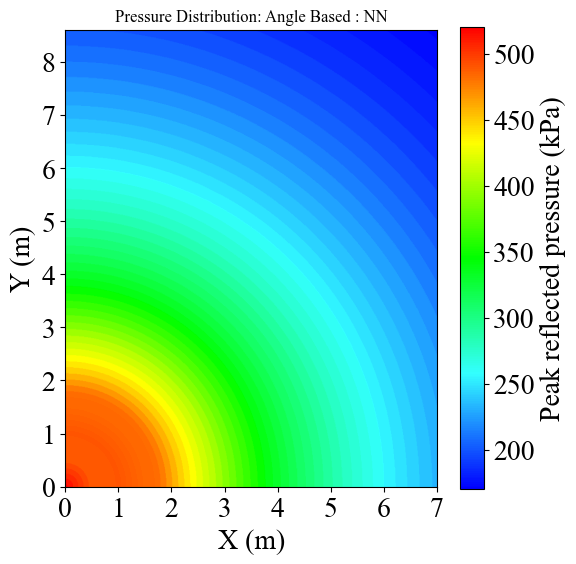

In [103]:
### NEURAL NETWORK PREDICTION AND VISUALIZATION ###
surface_coordinates, x_dataset, nn_prediction_results = neural_network_workflow()

18862/18862 [==============================] - 35s 2ms/step
value    225.515594
dtype: float32 value    135.672333
dtype: float32


C:\Users\z5379606\AppData\Local\Temp\ipykernel_17528\4206496932.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  colorbar = plt.colorbar(mappable,label='Error %' if prediction_method == 'Error Percentages' else 'Peak incident pressure (kPa)')


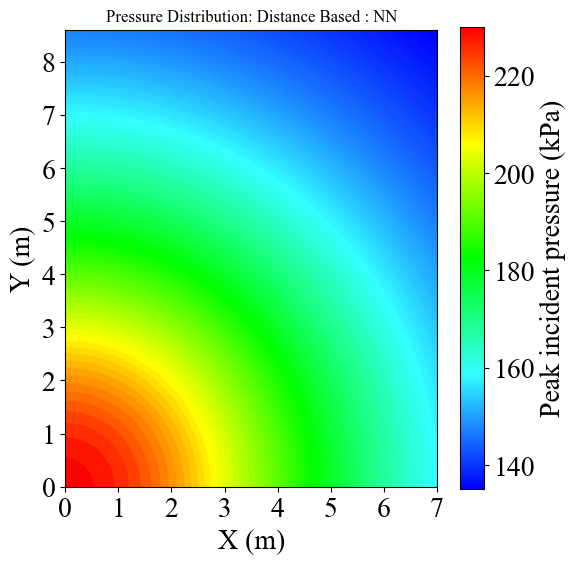

In [77]:
### NEURAL NETWORK PREDICTION AND VISUALIZATION ###
surface_coordinates, x_dataset, nn_prediction_results = neural_network_workflow()

18862/18862 [==============================] - 27s 1ms/step
value    156.332397
dtype: float32 value    77.754204
dtype: float32


C:\Users\z5379606\AppData\Local\Temp\ipykernel_17528\459978020.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  colorbar = plt.colorbar(mappable, label='Error %' if prediction_method == 'Error Percentages' else 'Peak impulse (kPa.ms)')


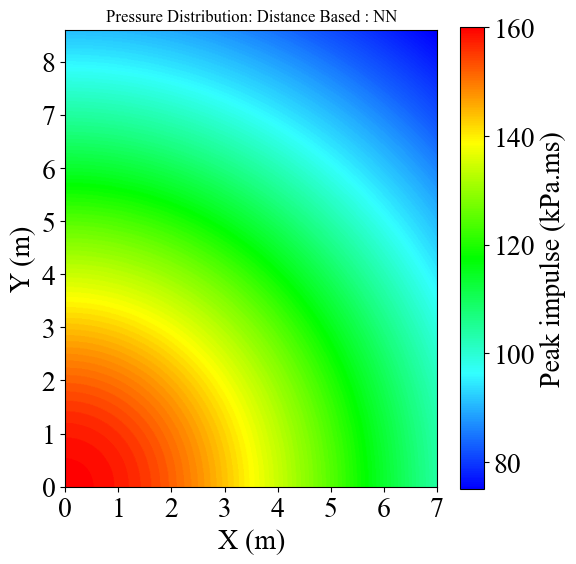

In [82]:
### NEURAL NETWORK PREDICTION AND VISUALIZATION ###
surface_coordinates, x_dataset, nn_prediction_results = neural_network_workflow()

18862/18862 [==============================] - 29s 2ms/step
value    23.636677
dtype: float32 value    6.701595
dtype: float32


C:\Users\z5379606\AppData\Local\Temp\ipykernel_17528\3272847569.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  colorbar = plt.colorbar(mappable, label='Error %' if prediction_method == 'Error Percentages' else 'Time of arrival (ms)')


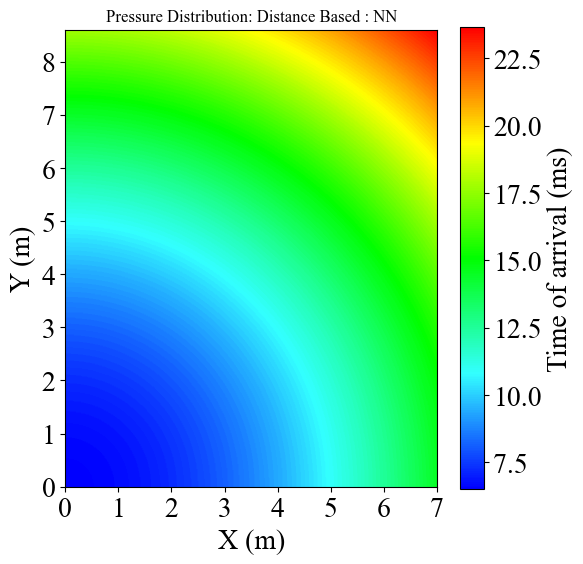

In [119]:
### NEURAL NETWORK PREDICTION AND VISUALIZATION ###
surface_coordinates, x_dataset, nn_prediction_results = neural_network_workflow()

## Numerical

C:\Users\z5379606\AppData\Local\Temp\ipykernel_17528\2107734049.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  colorbar = plt.colorbar(mappable,label='Error %' if prediction_method == 'Error Percentages' else 'Peak reflected pressure (kPa)')


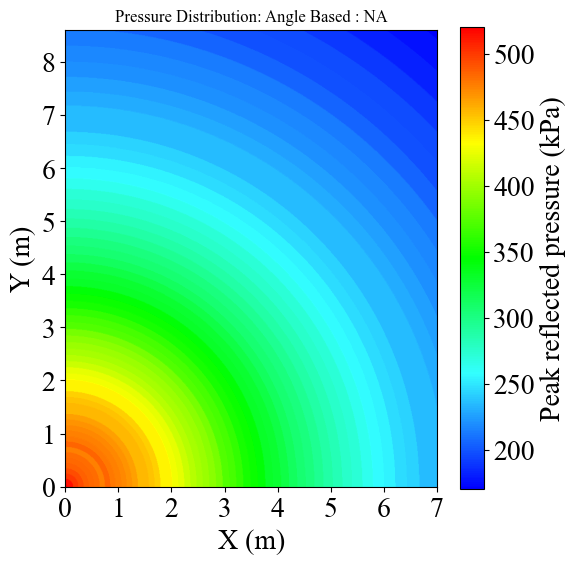

In [112]:
### NUMERICAL METHOD RESULTS PROCESSING ###
na_prediction_results = process_numerical_model_results(x_dataset[:, 1] if USE_DISTANCE_MODEL else x_dataset[:, 2], surface_coordinates) # pass the correct column from the x_dataset (angles or distances)

C:\Users\z5379606\AppData\Local\Temp\ipykernel_17528\2479957373.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  colorbar = plt.colorbar(mappable,label='Error %' if prediction_method == 'Error Percentages' else 'Peak incident pressure (kPa)')


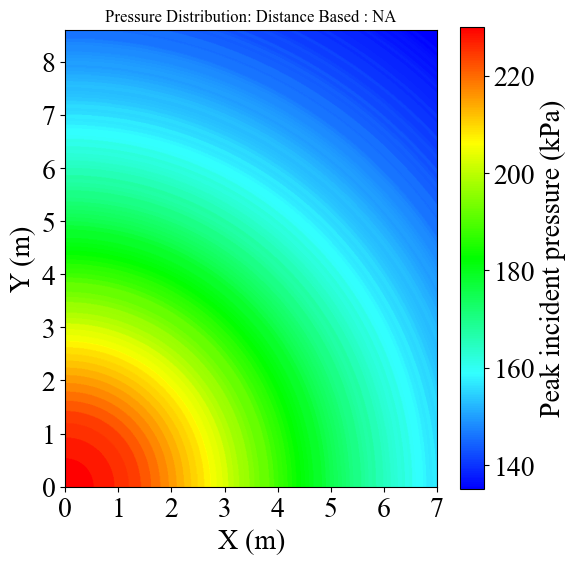

In [75]:
### NUMERICAL METHOD RESULTS PROCESSING ###
na_prediction_results = process_numerical_model_results(x_dataset[:, 1] if USE_DISTANCE_MODEL else x_dataset[:, 2], surface_coordinates) # pass the correct column from the x_dataset (angles or distances)

C:\Users\z5379606\AppData\Local\Temp\ipykernel_17528\2623148509.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  colorbar = plt.colorbar(mappable, label='Error %' if prediction_method == 'Error Percentages' else 'Peak impulse (kPa.ms)')


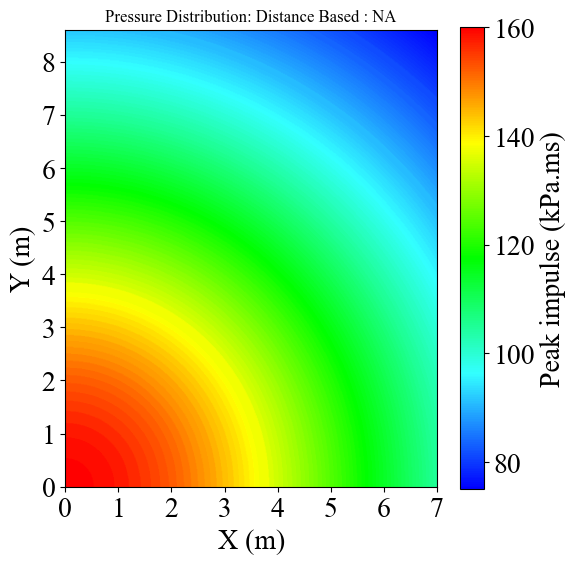

In [91]:
### NUMERICAL METHOD RESULTS PROCESSING ###
na_prediction_results = process_numerical_model_results(x_dataset[:, 1] if USE_DISTANCE_MODEL else x_dataset[:, 2], surface_coordinates) # pass the correct column from the x_dataset (angles or distances)

C:\Users\z5379606\AppData\Local\Temp\ipykernel_17528\3927819221.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  colorbar = plt.colorbar(mappable, label='Error %' if prediction_method == 'Error Percentages' else 'Time of arrival (ms)')


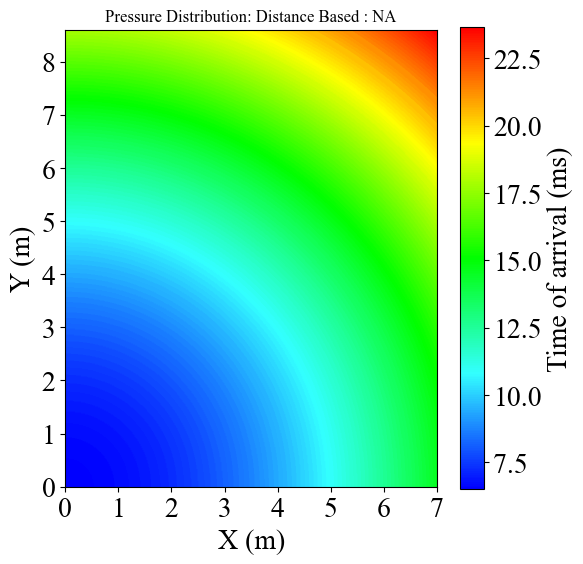

In [122]:
### NUMERICAL METHOD RESULTS PROCESSING ###
na_prediction_results = process_numerical_model_results(x_dataset[:, 1] if USE_DISTANCE_MODEL else x_dataset[:, 2], surface_coordinates) # pass the correct column from the x_dataset (angles or distances)

## Error

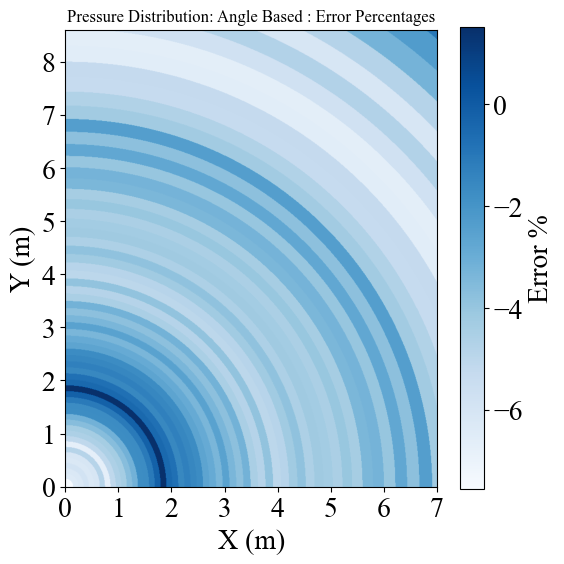

In [114]:
### ERROR PERCENTAGE CALCULATIONS ###
calculate_error_percentages(nn_prediction_results, na_prediction_results, surface_coordinates)
#PRP

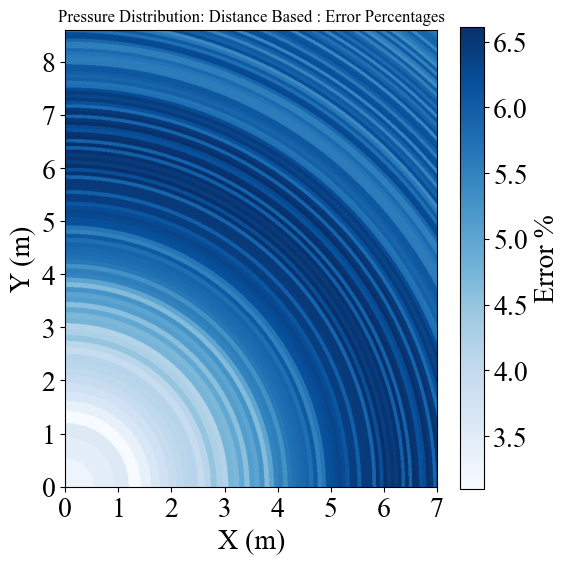

In [62]:
### ERROR PERCENTAGE CALCULATIONS ###
calculate_error_percentages(nn_prediction_results, na_prediction_results, surface_coordinates)
#PIP

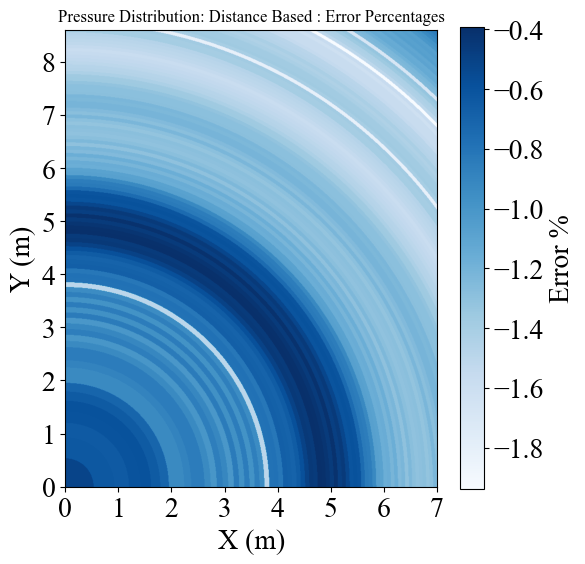

In [95]:
### ERROR PERCENTAGE CALCULATIONS ###
calculate_error_percentages(nn_prediction_results, na_prediction_results, surface_coordinates)
#PI

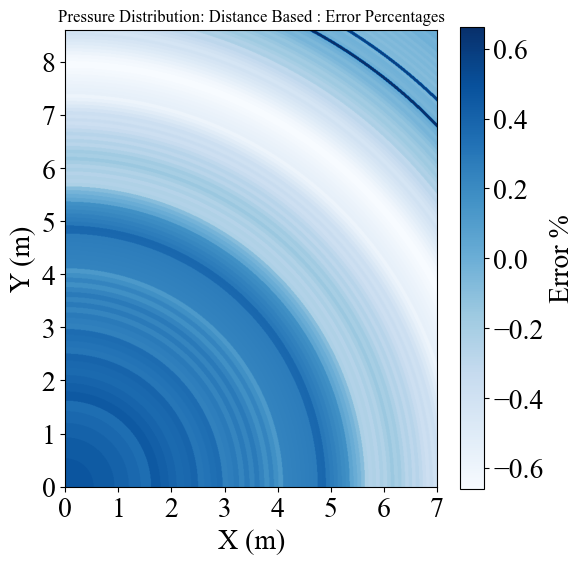

In [124]:
### ERROR PERCENTAGE CALCULATIONS ###
calculate_error_percentages(nn_prediction_results, na_prediction_results, surface_coordinates)
#AT